In [54]:
import wntr
import pandas as pd
from datetime import date
import folium
import pandas as pd
from pyproj import Proj

In [55]:
inp_file = "C:\\Users\\kaiorodrigues\\Desktop\\WNTR\\1_Data\\Vale_do_Amanhecer-Modelo_Final(Demanda_Nova).inp"


In [56]:
#Obtem os dados de diametro, tamanho e rugosidade do arquivo:
def Description_pipe(inp_file):
    network = wntr.network.WaterNetworkModel(inp_file)
    pipe_data = {}
    for link_name, link in network.links():
        if isinstance(link, wntr.network.elements.Pipe):
            length = link.length
            diameter = link.diameter
            roughness = link.roughness
            pipe_data[link_name] = {
                "Length (m)": length,
                "Diameter (m)": diameter,
                "Roughness (m)": roughness
            }
    pipe_table = pd.DataFrame(pipe_data).T
    return pipe_table
#  Realiza o processo de ETL inicial:
def etl_inp(pipe_data):
    pipe_data = pipe_data.reset_index()
    pipe_data.rename(columns={'index': 'ID'}, inplace=True) 
    return pipe_data

#Substituir valores da coluna material (kmeans permite apenas valores numericos)
def mapear_valores(valor):
    if valor == 'PVC':
        return 1
    elif valor == 'PVC DEFOFO':
        return 2
    elif valor == 'PEAD':
        return 3
    elif valor == 'FF':
        return 4
    else:
        return None



In [57]:
pipe_description = Description_pipe(inp_file)
pipe_description_ETL = etl_inp(pipe_description)
Description_material = pd.read_excel("C:/Users/kaiorodrigues/Desktop/WNTR/1_Data/Materiais/Rede_VAM.xlsx")
df_descricao_pipes = Description_material.loc[:, ['ID','DATA_IMPLA','MATERIAL']]
pipe_description_ETL['ID'] = pipe_description_ETL['ID'].str.replace('P', '999')
pipe_description_ETL['ID'] = pipe_description_ETL['ID'].astype(int)
merged_df = pd.merge(pipe_description_ETL, df_descricao_pipes, on='ID', how='left')
merged_df = merged_df.set_index('ID')
merged_df.to_excel('C:/Users/kaiorodrigues/Desktop/WNTR/1_Data/Materiais/test.xlsx',index=False)
# substitui os valores NAN por valores especificos
merged_df['DATA_IMPLA'].fillna(value='1996-03-06', inplace=True)
merged_df['MATERIAL'].fillna(value='PVC', inplace=True)
# Converta a coluna 'Data de Nascimento' para datetime
merged_df['DATA_IMPLA'] = pd.to_datetime(merged_df['DATA_IMPLA'])
today = date.today()
merged_df['Idade'] = today.year - merged_df['DATA_IMPLA'].dt.year
merged_df['Idade'] = merged_df['Idade'].fillna(0).astype(int)
merged_df['Material'] = merged_df['MATERIAL'].apply(mapear_valores)
merged_df = merged_df.drop(['DATA_IMPLA', 'MATERIAL'], axis=1)

c:\Users\kaiorodrigues\Anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Utilizando o método kmeans

In [58]:
#  Removemos a linha com id 45 pq vem da capitação (pois importa apenas oque vai após o reservatório)
capitacao = 45
merged_df = merged_df.drop(capitacao)

In [59]:
merged_df

,Length (m),Diameter (m),Roughness (m),Idade,Material
ID,,,,,
0,0.812481,0.25,135.0,27,1
1,6.294194,0.30,135.0,27,2
10,226.210125,0.11,132.5,27,1
100,14.673712,0.06,132.5,27,1
101,49.187364,0.06,132.5,27,1
...,...,...,...,...,...
99943,8.220000,0.25,135.0,27,1
99945,9.280000,0.25,135.0,27,1
99947,10.100000,0.25,135.0,27,1


In [60]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Realizar a padronização dos dados utilizando o StandardScaler
n_clusters = 10

# criar um objeto KMeans e ajustá-lo ao df_descricao_pipes
kmeans = KMeans(n_clusters=n_clusters).fit(merged_df)

# obter as etiquetas de cluster para cada registro
labels = kmeans.labels_

# obter os centróides de cada cluster
centroids = kmeans.cluster_centers_

# imprimir as etiquetas de cluster e os centróides
centroides = kmeans.cluster_centers_

# Acesse os rótulos dos clusters atribuídos a cada amostra
rotulos = kmeans.labels_

# Exiba os resultados
print("Centroides:")
print(centroides)
print("Rótulos dos clusters:")
print(rotulos)

Centroides:
[[1.198e+02 7.304e-02 1.325e+02 2.692e+01 1.458e+00]
 [6.279e+00 9.703e-02 1.338e+02 2.532e+01 1.839e+00]
 [2.119e+02 6.495e-02 1.329e+02 2.700e+01 1.211e+00]
 [6.251e+01 8.724e-02 1.334e+02 2.677e+01 1.375e+00]
 [4.208e+02 6.000e-02 1.325e+02 2.700e+01 1.000e+00]
 [3.864e+01 5.701e-02 1.337e+02 2.551e+01 1.841e+00]
 [1.512e+02 9.873e-02 1.333e+02 2.700e+01 1.100e+00]
 [2.667e+02 7.000e-02 1.325e+02 2.700e+01 1.000e+00]
 [8.810e+01 8.776e-02 1.331e+02 2.691e+01 1.133e+00]
 [2.109e+01 8.920e-02 1.338e+02 2.609e+01 1.721e+00]]
Rótulos dos clusters:
[1 1 2 9 5 1 6 1 1 1 1 1 1 1 3 8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 5 1 9 5 5 5 1 1 5 9 9 9 1 1 9 9 5 5 5 9 9 5 5 5 9 1 1 3 5 5 9 5 9 9 1 5 5 9 5 5 1 1 9 1 1 1 5 9 1 1 9 9 1 3 5 1 5 1 1 1 3 1 5 9 5 1 9 1 1 1 3 9 9 8 9 9 3 5 5 5 5 9 9 5 9 3 8 8 5 3 1 6 8 5 9 9 9 5 5 8 8 8 8 8 5 1 3 3 5 2 1
 5 2 6 7 8 9 8 3 1 9 6 3 0 0 9 8 8 8 8 1 6 3 6 9 0 5 1 2 3 3 1 3 3 1 7 9 1 9 1 9 2 9 4 2 2 2 2 2 2 2 2 2 9 2 3 9 6 3 6 9 0 0 0 5 0 1 1 3

In [61]:
merged_df['Grupo'] = labels

In [63]:
merged_df.to_excel("Cluster.xlsx")

# Testando pelo método de plotar apartir do trecho

Este método consiste em pegar o nó inicial de cada trecho, juntar o grupo + trecho + nó em um unico dataframe, depois criar um Series apenas com o nó e o grupo, em seguida plotar no mapa

In [64]:
import wntr

# Carregar o modelo da rede de água
wn = wntr.network.WaterNetworkModel(inp_file)
pipe_ids = wn.pipe_name_list

# Imprimir os IDs dos nós
print(pipe_ids)
data = []
for i in pipe_ids:
    node_name = wn.get_link(i).start_node_name
    data.append({'ID': i, 'nó': node_name})

df = pd.DataFrame(data)
df['ID'] = df['ID'].str.replace('P', '999')
print(df)

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '22

In [65]:
df

,ID,nó
0,0,J10
1,1,J14
2,10,J38
3,100,J22
4,101,J274
...,...,...
585,99945,J1112
586,99947,J1112
587,99949,RAP.VAM.001.LIT.001.000
588,99951,RAP.VAM.001.LIT.002.000


In [66]:
merged_df = merged_df.reset_index()
df['ID'] = df['ID'].astype(int)
df_final = pd.merge(merged_df, df, on='ID', how='left')
df_final = df_final.set_index('ID')


In [67]:
df_pop = df_final[['nó' , 'Grupo']]
df_pop = df_pop.drop_duplicates(subset=['nó'])
df_pop = df_pop.set_index('nó',drop=True)
df_pop.index.name = None

In [68]:
series = df_pop['Grupo']
print(series)
print(type(series))

J10                        1
J14                        1
J38                        2
J22                        9
J274                       5
                          ..
V8002_ND                   9
J1110                      1
J1112                      1
RAP.VAM.001.LIT.001.000    1
RAP.VAM.001.LIT.002.000    1
Name: Grupo, Length: 443, dtype: int32
<class 'pandas.core.series.Series'>


In [69]:
df= [['J10',215665.95, 8264835.29],['RAP.VAM.001.LIT.001.000', 215438.59, 8264758.98]]
df = pd.DataFrame (df, columns = ['Nó','coordenada_x','coordenada_y'])
myproj = Proj('+proj=utm + zone=23 + south + ellps = WGS84', preserve_units = False)
df['Long'],df['lat'] = myproj(df['coordenada_x'].values,df['coordenada_y'].values,inverse=True)
df

,Nó,coordenada_x,coordenada_y,Long,lat
0,J10,215665.95,8264835.29,-47.652522,-15.678607
1,RAP.VAM.001.LIT.001.000,215438.59,8264758.98,-47.654650,-15.679270


In [70]:
longlat_map = {'J10':(-47.652522,-15.678607),'RAP.VAM.001.LIT.001.000':(-47.654650,-15.679270)}
wn2 = wntr.morph.convert_node_coordinates_to_longlat(wn, longlat_map)
length = wn2.query_link_attribute('length')
wntr.graphics.plot_leaflet_network(wn2, node_attribute=series, node_size=4,link_width=1,node_range=[0,4], filename='length1.html')

# Testando pelo método de plotar apartir do nó


In [15]:
import wntr
import pandas as pd
from datetime import date
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
df = pd.read_excel("C:/Users/kaiorodrigues/Desktop/WNTR/1_Data/Materiais/Coordenada.xlsx")
df

,Nó,Long,lat
0,J10,-47.652522,-15.678607
1,J100,-47.658211,-15.680257
2,J1000,-47.647968,-15.671222
3,J1002,-47.648220,-15.672854
4,J1004,-47.646978,-15.673864
...,...,...,...
518,J998,-47.651128,-15.672340
519,V8002_NU,-47.653317,-15.676426
520,V8002_ND,-47.653226,-15.676390
521,RAP.VAM.001.LIT.001.000,-47.654630,-15.679310


In [17]:
x = df[["lat", "Long"]]
x.head()

,lat,Long
0,-15.678607,-47.652522
1,-15.680257,-47.658211
2,-15.671222,-47.647968
3,-15.672854,-47.648220
4,-15.673864,-47.646978


In [18]:
model = KMeans(n_clusters=5)
y_kmeans = model.fit_predict(x)

In [19]:
df['y'] = y_kmeans

In [20]:
df.head()

,Nó,Long,lat,y
0,J10,-47.652522,-15.678607,3
1,J100,-47.658211,-15.680257,2
2,J1000,-47.647968,-15.671222,1
3,J1002,-47.648220,-15.672854,1
4,J1004,-47.646978,-15.673864,1


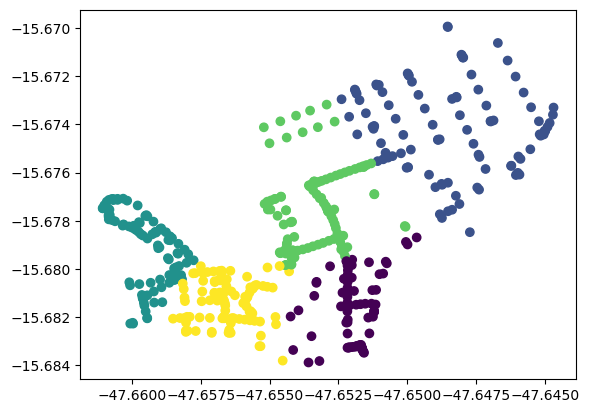

In [21]:
plt.scatter(df['Long'], df['lat'], c=df['y'])

In [22]:
model.inertia_

0.0019832169162474077

In [23]:
cluster1 = df[['lat', "Long"]][df['y'] == 0].values.tolist()
cluster2 = df[['lat', "Long"]][df['y'] == 1].values.tolist()
cluster3 = df[['lat', "Long"]][df['y'] == 2].values.tolist()
cluster4 = df[['lat', "Long"]][df['y'] == 3].values.tolist()
cluster5 = df[['lat', "Long"]][df['y'] == 4].values.tolist()

In [24]:
df_no = df[['Nó' , 'y']]
df_no = df_no.set_index('Nó',drop=True)
df_no.index.name = None

In [25]:
series = df_no['y']
print(series)
print(type(series))

J10                        3
J100                       2
J1000                      1
J1002                      1
J1004                      1
                          ..
J998                       1
V8002_NU                   3
V8002_ND                   3
RAP.VAM.001.LIT.001.000    3
RAP.VAM.001.LIT.002.000    3
Name: y, Length: 523, dtype: int32
<class 'pandas.core.series.Series'>


In [26]:
longlat_map = {'J10':(-47.652522,-15.678607),'RAP.VAM.001.FIT.001.000.000':(-47.654437,-15.679285)}
wn2 = wntr.morph.convert_node_coordinates_to_longlat(wn, longlat_map)
length = wn2.query_link_attribute('length')
wntr.graphics.plot_leaflet_network(wn2, node_attribute=series, node_size=4,link_width=1,node_range=[0,5], filename='length_nó.html')

KeyError: 'RAP.VAM.001.FIT.001.000.000'